In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

In [4]:
import h5py

import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

# download HDF5 format data

https://arxiv.org/abs/2103.01054

In [5]:
!curl -o levels.h5 https://arxiv.org/src/2103.01054v1/anc/levels.h5 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1631k    0 1631k    0     0   184k      0 --:--:--  0:00:08 --:--:--  236k


In [6]:
f = h5py.File('levels.h5', 'r')

In [7]:
# check format
print(f['A653/P000/pseudoscalar'])

print(f['A653/P000/octet_baryon'])

print(f['A653/P000/spin_zero'])

print(f.keys())
print(f['N300'].keys())

<HDF5 dataset "pseudoscalar": shape (1001,), type "<f8">
<HDF5 dataset "octet_baryon": shape (1001,), type "<f8">
<HDF5 dataset "spin_zero": shape (1001, 3), type "<f8">
<KeysViewHDF5 ['A653', 'B450', 'E1', 'E5', 'H101', 'H200', 'N202', 'N300', 'U103']>
<KeysViewHDF5 ['P000', 'P001', 'P002', 'P011', 'P111']>


# configuration info

In [18]:
df_conf = pd.read_csv('conf_info.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
1,N202,3,3.55,0.137000,48,128,open,0.0642,412,3.1,6.4,1.17,899,8,10788,68,0.004122,3.074
2,H200,3,3.55,0.137000,32,96,open,0.0642,419,2.1,4.4,1.19,2000,8,16000,20,0.004122,3.074
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
4,H101,3,3.40,0.136760,32,96,open,0.0865,417,2.8,5.9,1.16,2016,4,12096,48,0.007482,2.281
5,U103,3,3.40,0.136760,24,128,open,0.0865,414,2.1,4.4,1.18,5658,5,45264,20,0.007482,2.281
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989
7,E5,2,5.30,0.136250,32,64,periodic,0.0658,436,2.1,4.7,1.29,2000,4,16000,30,0.004330,2.999
8,E1,2,5.30,0.135500,32,64,periodic,0.0658,978,2.1,10.4,2.03,168,8,2688,30,0.004330,2.999


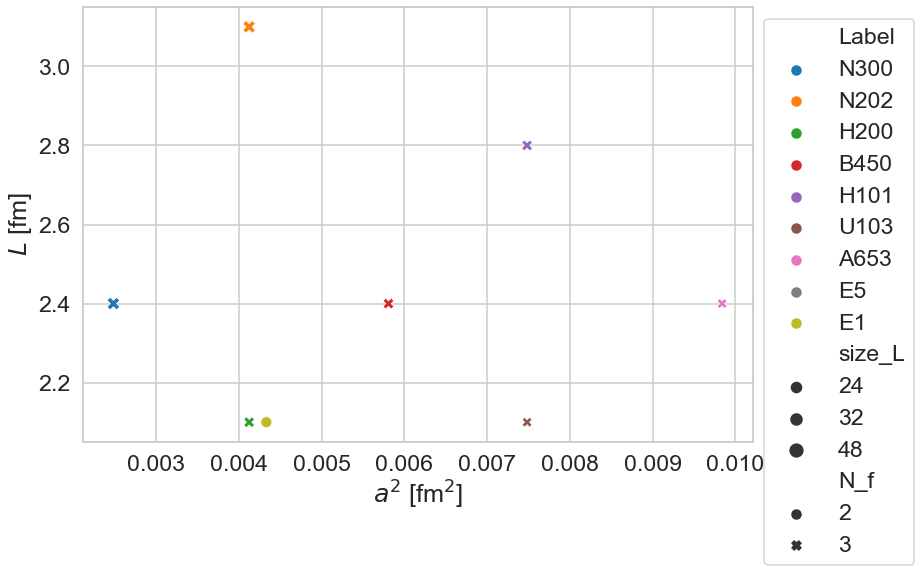

In [47]:
with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=df_conf, x='a2 [fm2]', y='L [fm]', hue='Label', ax=ax, size='size_L', style='N_f', size_norm=(0,48))
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]')

In [48]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()

In [49]:
label_list = list(df_conf['Label'])

In [50]:
def get_mass(label, frame='P000', kind='octet_baryon'):
    try:
        vals = np.array(f.get(f'{label}/{frame}/{kind}'))
        avg = vals[0]
        bs_samples = vals[1:]
        return avg, bs_samples
    
    except:
        return None, None

    
## baryon mass info.

tmp = {}
CI = 95
for label in label_list:
    val, bs_samples = get_mass(label, kind='octet_baryon')
    val_lower = np.percentile(bs_samples, (100 - CI)*0.5)
    val_upper = np.percentile(bs_samples, 100 - (100 - CI)*0.5)
    a_inv = a_inv_dic.get(label)
    tmp[label] = [(val*a_inv).round(3), (val_lower*a_inv).round(3), (val_upper*a_inv).round(3)]

res = pd.DataFrame(tmp).T.rename(columns={0: 'm_B [GeV]', 1: 'm_B(lower)', 2: 'm_B(upper)'})
res

,m_B [GeV],m_B(lower),m_B(upper)
N300,1.217,1.210,1.223
N202,1.167,1.163,1.171
H200,1.198,1.188,1.207
B450,1.180,1.175,1.184
H101,1.165,1.160,1.171
U103,1.179,1.174,1.185
A653,1.162,1.157,1.168
E5,1.292,1.288,1.296
E1,2.027,2.021,2.033


# check central values of energy shifts

In [51]:
label = 'E5'
    
def get_p2(label):
    m_B = get_mass(label, kind='octet_baryon')[0]

    tmp = {}
    for key in f.get(f'{label}').keys():
        E_list = f.get(f'{label}/{key}/spin_zero')[0,:]
        p_unit = 2.0*np.pi/L_dic.get(label)
        psq = int(key[1])**2 + int(key[2])**2 + int(key[3])**2
        p2_list = (1/4)*E_list**2 - m_B**2 - psq * p_unit**2/4

        tmp[key] = p2_list*a_inv_dic.get(label)**2
    return tmp

res = get_p2('E5')
res

{'P000': array([-0.07837824,  0.2854431 ,  0.69842461]),
 'P001': array([-0.01799241,  0.3780153 ]),
 'P002': array([-0.07104471]),
 'P011': array([0.04739199, 0.13816206]),
 'P111': array([0.1187514, 0.205469 ])}

In [52]:
# exact value in Fig. S4 (Left) spin-zero levels
x0 = [142.7016, 67.57]
y0 = [0, 0.4]
conv_px = lambda x: (y0[0] - y0[1])/(x0[0] - x0[1]) * (x - x0[1]) + y0[1]

_val = {'P000': [157.4215, 89.0934, 11.532],
       'P001': [146.0805, 71.707],
       'P011': [133.8008, 116.7539],
       'P111': [120.3992, 104.1129],
       'P002': [156.0441]}

for key in ['P000', 'P001', 'P002', 'P011', 'P111']:
    print(key)
    for _ in _val.get(key):
        print('{:.4f} '.format(conv_px(_)), end='')
    print('')
# consistent with upper result

P000
-0.0784 0.2854 0.6983 
P001
-0.0180 0.3780 
P002
-0.0710 
P011
0.0474 0.1381 
P111
0.1187 0.2054 


In [53]:
label = 'E5'
def plot_energy_level(label):
    res = get_p2(label)

    fig, ax = plt.subplots(figsize=(8, 4))
    xticks = []
    xticklabels = []
    for ith, key in enumerate(['P000', 'P001', 'P011', 'P111', 'P002']):
        ys = res.get(key)
        xs = np.zeros_like(ys) + ith
        xticks.append(ith)
        xticklabels.append(key)
        ax.plot(xs, ys, label=key, marker='o', linestyle='',
               color='C0')


    ax.axhline(0, color='black', ls='--')
    ax.set(xticks=xticks, xticklabels=xticklabels, xlim=(xticks[0]-0.5, xticks[-1]+0.5),
          title=fr'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV])', ylabel=r'$p^2$ [GeV$^2$]')


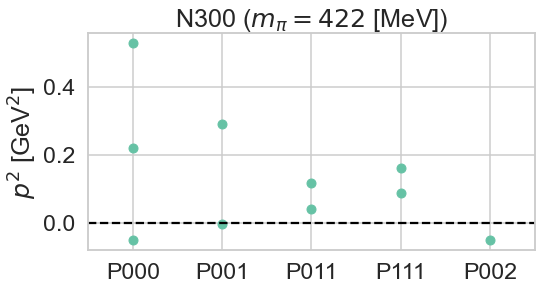

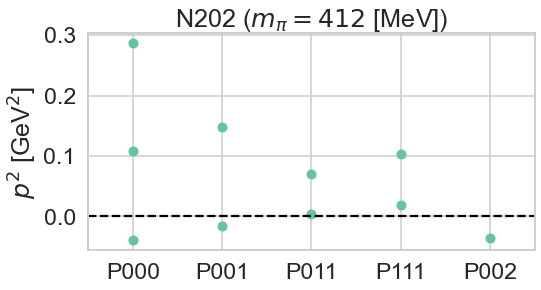

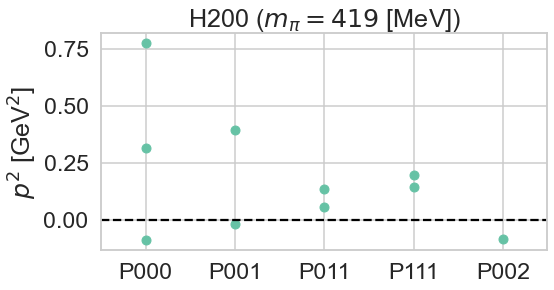

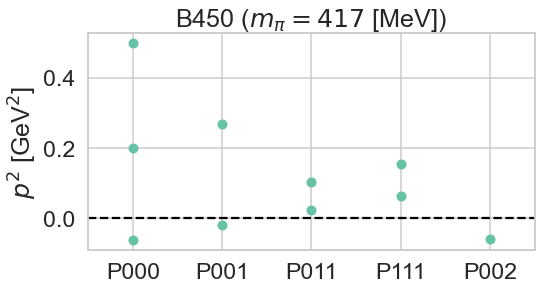

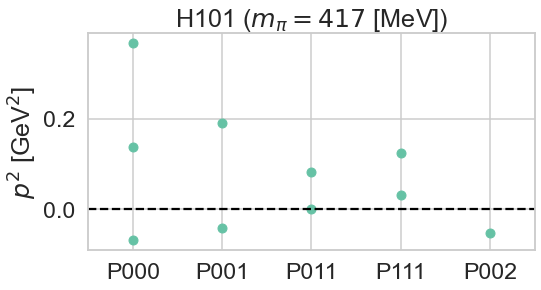

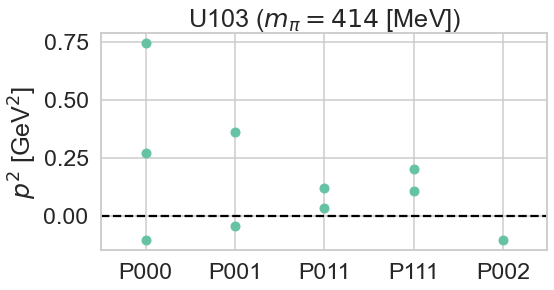

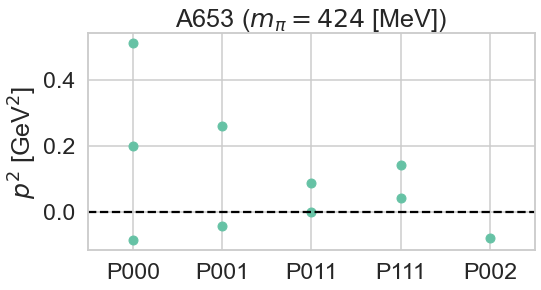

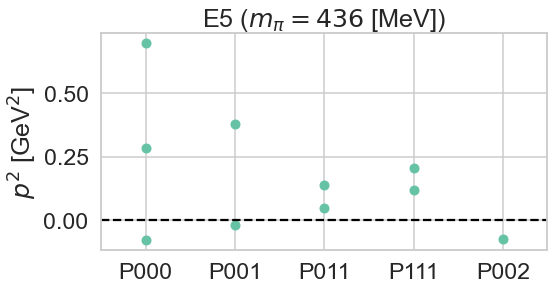

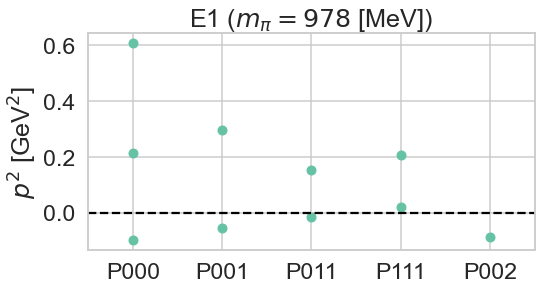

In [54]:
for label in label_list:
    plot_energy_level(label)